In [15]:
%pip install pydicom

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import tensorflow as tf
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

2024-12-07 15:55:53.956422: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-07 15:55:55.434443: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-07 15:55:59.481999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
def dice_coef(y_true, y_pred):
    smooth = 1e-20
    y_true_f = K.cast(y_true, 'float32')
    intersection = K.sum(y_true_f * y_pred)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_coef(y_true, y_pred):
    smooth = 1e-20
    y_true_f = K.cast(y_true, 'float32')
    intersection = K.sum(y_true_f * y_pred)
    union = K.sum(y_true_f + y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def jaccard_coef_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred)

# Загрузка модели
model = load_model(MODEL_PATH, custom_objects={"dice_coef_loss": dice_coef_loss, 'dice_coef': dice_coef})

# Функция для загрузки и предобработки DICOM файла
def preprocess_dicom(dicom_path, target_size=(512, 512)):
    # Загрузка DICOM файла
    dicom = pydicom.dcmread(dicom_path)
    image = dicom.pixel_array.astype(np.float32)

    # Нормализация пикселей
    image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Нормализация в [0, 1]

    # Убедимся, что изображение имеет 3 измерения [H, W, C]
    if len(image.shape) == 2:  # Если изображение черно-белое
        image = np.expand_dims(image, axis=-1)  # Добавляем канал (H, W, 1)

    # Изменение размера до (512, 512)
    image = tf.image.resize(image, target_size).numpy()

    # Преобразование в формат [B, C, H, W] для модели
    image = np.expand_dims(image, axis=0)  # Добавляем batch размер (1, H, W, C)
    image = np.transpose(image, (0, 3, 1, 2))  # Преобразуем (B, H, W, C) -> (B, C, H, W)

    print("Preprocessed image shape:", image.shape)  # Проверяем форму
    return image


def predict_segmentation(model, dicom_path, target_size=(512, 512)):
    # Предобработка изображения
    input_image = preprocess_dicom(dicom_path, target_size)

    # Проверка формы перед подачей в модель
    print("Input image shape before prediction:", input_image.shape)

    # Выполнение предсказания
    prediction = model.predict(input_image)

    # Получение сегментационной маски (порог 0.5)
    segmentation_mask = (prediction[0, 0] > 0.5).astype(np.uint8)
    print("Segmentation mask shape:", segmentation_mask.shape)

    return segmentation_mask

def visualize_segmentation(dicom_path, segmentation_mask):
    # Загрузка исходного изображения из DICOM файла
    original_image = pydicom.dcmread(dicom_path).pixel_array
    
    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image, cmap="gray")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.title("Segmentation Mask")
    plt.imshow(original_image, cmap="gray")
    plt.imshow(segmentation_mask, alpha=0.5)
    plt.axis("off")
    
    plt.show()

Preprocessed image shape: (1, 1, 512, 512)
Input image shape before prediction: (1, 1, 512, 512)


2024-12-07 15:56:15.771438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900


1/1 [==============================] - 3s 3s/step
Segmentation mask shape: (512, 512)


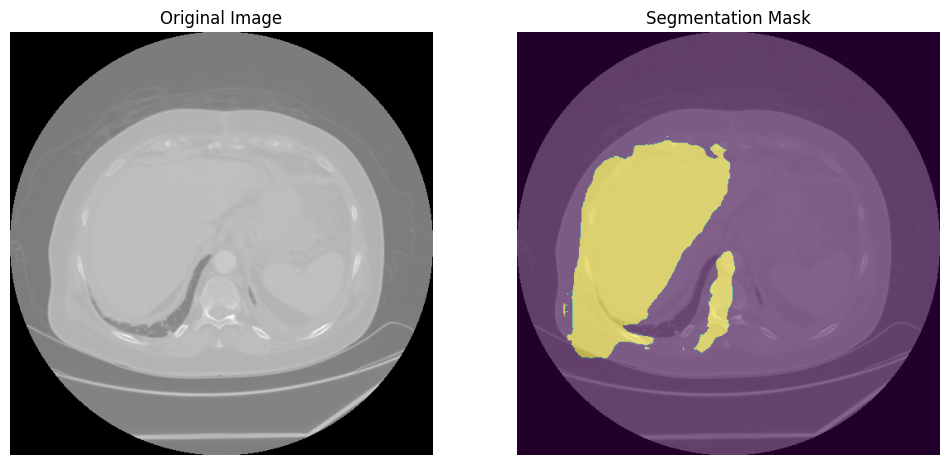

In [5]:
# Путь к сохраненной модели
MODEL_PATH = "/home/jupyter/datasphere/project/model/unet_r.h5"
DICOM_PATH = "/home/jupyter/datasphere/datasets/Data1/Data1/IM-0001-0059.dcm"

segmentation_mask = predict_segmentation(model, DICOM_PATH)

# Сохранение сегментационной маски
# save_segmentation_mask(segmentation_mask, OUTPUT_PATH)

# Визуализация исходного изображения и сегментационной маски
original_image = pydicom.dcmread(DICOM_PATH).pixel_array
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Segmentation Mask")
plt.imshow(original_image, cmap="gray")
plt.imshow(segmentation_mask, alpha=0.5)
plt.axis("off")
plt.show()

In [ ]:
import os

# Путь к директории с DICOM файлами
DICOM_DIR = "/home/jupyter/datasphere/datasets/Data1/Data1"  # Укажите свой путь

# Проходим по файлам в директории
for dicom_file in os.listdir(DICOM_DIR):
    # Проверяем, что файл является DICOM файлом и начинается с "IM-0001"
    if dicom_file.endswith(".dcm") and dicom_file.startswith("IM-0001"):
        dicom_path = os.path.join(DICOM_DIR, dicom_file)
        print(dicom_path)
#         # Выполнение сегментации
#         segmentation_mask = predict_segmentation(model, dicom_path)
        
#         # Сохранение сегментационной маски
#         # output_path = f"segmentation_result_{os.path.splitext(dicom_file)[0]}.png"
#         # save_segmentation_mask(segmentation_mask, output_path)
        
#         # print(f"Сегментация для файла {dicom_file} завершена. Результат сохранен в {output_path}")
        
#         # Визуализируем результат
#         visualize_segmentation(dicom_path, segmentation_mask)
